In [76]:
import numpy as np
import numpy

In [77]:
def gen_var_combo(num_dim, latent_dim):
    '''
    generates a combination of the latent variables that each function depends on. 
    0 represents the identity.
    
    '''
    vars_ = list(range(latent_dim))
    p = np.full(latent_dim, ((1/(latent_dim))))
    #p[0] = .5
    var_combo = np.random.choice(vars_, size = (num_dim, latent_dim), p = p)
    return var_combo

In [78]:
def gen_func_combo(num_dim, latent_dim):
    '''
    generates a random function dependant on latent dimesnions for each dimnesion
    
    '''
    funcs = ['+', '-', '*', '/']
    func_combo = np.random.choice(funcs, size = (num_dim, latent_dim-1))
    return func_combo

In [79]:
def gen_latent_space_from_sample(latent_samples, num_dim):
    '''
    Generates a num_samples by num_dimensions matrix where each dimension is a function
    of the latent dimensions.
    
    '''
    num_samples = latent_samples.shape[0]
    num_latent_dim = latent_samples.shape[1]
    
    var_combo, func_combo, weights = gen_space_params(num_dim, num_latent_dim)

    super_sample = []
    for sample in range(num_samples):
        dimension =[]
        for dim in range(num_dim):
            weight = np.multiply(latent_samples[sample, :], weights[dim])
            dem = weight[var_combo[dim, 0]]
            for lat in range(num_latent_dim-1):
                if(func_combo[dim, lat] == '+'):
                    dem = dem + weight[int(var_combo[dim, lat])]
                elif(func_combo[dim, lat] == '-'):
                    dem = dem + weight[int(var_combo[dim, lat])]
                elif (func_combo[dim, lat] == '*'):
                    dem = dem * weight[int(var_combo[dim, lat])]
                elif (func_combo[dim, lat] == '/'):
                    dem = dem * weight[int(var_combo[dim, lat])]
            dimension.append(dem)
        #print(dimension)
        #dimension = np.concatenate(dimension)
        super_sample.append(dimension)
    return numpy.array(super_sample), latent_samples

In [80]:
def gen_space_params(num_dim, num_latent_dim):
    '''
    gets the parameters used to construct latent space
    
    '''
    var_combo = gen_var_combo(num_dim, num_latent_dim)
    func_combo = gen_func_combo(num_dim, num_latent_dim)
    weights = np.random.rand(num_dim, num_latent_dim)
    return var_combo, func_combo, weights

In [81]:
from numpy.random import multivariate_normal
from sklearn.datasets import make_spd_matrix

In [82]:
a = np.concatenate([multivariate_normal(np.random.uniform(3, 5, 4), make_spd_matrix(4), 3000), np.ones((3000, 1))], axis = 1)
d = np.concatenate([multivariate_normal(np.random.uniform(7, 9, 4), make_spd_matrix(4), 3000), 3*np.ones((3000, 1))], axis = 1)
e = np.concatenate([multivariate_normal(np.random.uniform(12,14 , 4), make_spd_matrix(4), 3000), 2*np.ones((3000, 1))], axis = 1)

In [83]:
b = np.concatenate([multivariate_normal(np.random.uniform(-2, 2 , 4), make_spd_matrix(4), 3000), np.zeros((3000, 1))], axis = 1)
c = np.concatenate([a, b, d , e])
np.random.shuffle(c)

In [84]:
from numpy import genfromtxt
c= genfromtxt('gen_dat.csv', delimiter=',')

In [85]:
labels = c[:, 4]
c = c[:, :4]
c.shape

(12000, 4)

In [86]:


samp, lat = gen_latent_space_from_sample(c, num_dim = 60)

In [87]:
from keras.layers import Input, Dense
from keras.models import Model

# this is the size of our encoded representations
encoding_dim = 4  # 32 floats -> compression of factor 24.5, assuming the input is 784 floats
input_dim = 30
# this is our input placeholder
input_img = Input(shape=(60,))
# "encoded" is the encoded representation of the input
x = Dense(input_dim, activation = 'relu')(input_img)
x = Dense(input_dim, activation = 'relu')(input_img)
encoded = Dense(encoding_dim, activation='sigmoid')(x)
# "decoded" is the lossy reconstruction of the input
decoded = Dense(60, activation='sigmoid')(encoded)

# this model maps an input to its reconstruction
autoencoder = Model(input_img, decoded)

In [88]:
encoder = Model(input_img, encoded)

In [89]:
encoded_input = Input(shape=(encoding_dim,))
# retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]
# create the decoder model
decoder = Model(encoded_input, decoder_layer(encoded_input))

In [90]:
autoencoder.compile(optimizer='sgd', loss='mean_squared_error')

In [91]:
samp.shape

(12000, 60)

In [92]:
samp.max(axis = 0).shape

(60,)

In [93]:
x_train = samp[:10000, :]/samp[:10000, :].max(axis = 0)
x_test = samp[10000:, :]/samp[:10000, :].max(axis = 0)

In [94]:
autoencoder.fit(x_train, x_train,
                epochs=5000,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))

Train on 10000 samples, validate on 2000 samples
Epoch 1/5000
10000/10000 [==============================] - 2s 189us/step - loss: 0.1470 - val_loss: 0.1462
Epoch 2/5000
10000/10000 [==============================] - 0s 12us/step - loss: 0.1467 - val_loss: 0.1459
Epoch 3/5000
10000/10000 [==============================] - 0s 13us/step - loss: 0.1464 - val_loss: 0.1456
Epoch 4/5000
10000/10000 [==============================] - 0s 11us/step - loss: 0.1462 - val_loss: 0.1453
Epoch 5/5000
10000/10000 [==============================] - 0s 12us/step - loss: 0.1459 - val_loss: 0.1450
Epoch 6/5000
10000/10000 [==============================] - 0s 13us/step - loss: 0.1456 - val_loss: 0.1448
Epoch 7/5000
10000/10000 [==============================] - 0s 12us/step - loss: 0.1453 - val_loss: 0.1445
Epoch 8/5000
10000/10000 [==============================] - 0s 13us/step - loss: 0.1451 - val_loss: 0.1442
Epoch 9/5000
10000/10000 [==============================] - 0s 11us/step - loss: 0.1448 - val_

10000/10000 [==============================] - 0s 13us/step - loss: 0.1284 - val_loss: 0.1277
Epoch 77/5000
10000/10000 [==============================] - 0s 12us/step - loss: 0.1282 - val_loss: 0.1275
Epoch 78/5000
10000/10000 [==============================] - 0s 12us/step - loss: 0.1280 - val_loss: 0.1272
Epoch 79/5000
10000/10000 [==============================] - 0s 11us/step - loss: 0.1278 - val_loss: 0.1270
Epoch 80/5000
10000/10000 [==============================] - 0s 12us/step - loss: 0.1276 - val_loss: 0.1268
Epoch 81/5000
10000/10000 [==============================] - 0s 12us/step - loss: 0.1273 - val_loss: 0.1266
Epoch 82/5000
10000/10000 [==============================] - 0s 12us/step - loss: 0.1271 - val_loss: 0.1264
Epoch 83/5000
10000/10000 [==============================] - 0s 13us/step - loss: 0.1269 - val_loss: 0.1262
Epoch 84/5000
10000/10000 [==============================] - 0s 14us/step - loss: 0.1267 - val_loss: 0.1259
Epoch 85/5000
10000/10000 [===============

10000/10000 [==============================] - 0s 10us/step - loss: 0.1137 - val_loss: 0.1130
Epoch 152/5000
10000/10000 [==============================] - 0s 10us/step - loss: 0.1135 - val_loss: 0.1128
Epoch 153/5000
10000/10000 [==============================] - 0s 12us/step - loss: 0.1133 - val_loss: 0.1126
Epoch 154/5000
10000/10000 [==============================] - 0s 11us/step - loss: 0.1132 - val_loss: 0.1124
Epoch 155/5000
10000/10000 [==============================] - 0s 11us/step - loss: 0.1130 - val_loss: 0.1123
Epoch 156/5000
10000/10000 [==============================] - 0s 11us/step - loss: 0.1128 - val_loss: 0.1121
Epoch 157/5000
10000/10000 [==============================] - 0s 11us/step - loss: 0.1126 - val_loss: 0.1119
Epoch 158/5000
10000/10000 [==============================] - 0s 10us/step - loss: 0.1125 - val_loss: 0.1117
Epoch 159/5000
10000/10000 [==============================] - 0s 11us/step - loss: 0.1123 - val_loss: 0.1116
Epoch 160/5000
10000/10000 [======

10000/10000 [==============================] - 0s 11us/step - loss: 0.1016 - val_loss: 0.1009
Epoch 227/5000
10000/10000 [==============================] - 0s 11us/step - loss: 0.1014 - val_loss: 0.1008
Epoch 228/5000
10000/10000 [==============================] - 0s 11us/step - loss: 0.1013 - val_loss: 0.1006
Epoch 229/5000
10000/10000 [==============================] - 0s 12us/step - loss: 0.1012 - val_loss: 0.1005
Epoch 230/5000
10000/10000 [==============================] - 0s 11us/step - loss: 0.1010 - val_loss: 0.1003
Epoch 231/5000
10000/10000 [==============================] - 0s 11us/step - loss: 0.1009 - val_loss: 0.1002
Epoch 232/5000
10000/10000 [==============================] - 0s 12us/step - loss: 0.1007 - val_loss: 0.1001
Epoch 233/5000
10000/10000 [==============================] - 0s 11us/step - loss: 0.1006 - val_loss: 0.0999
Epoch 234/5000
10000/10000 [==============================] - 0s 12us/step - loss: 0.1004 - val_loss: 0.0998
Epoch 235/5000
10000/10000 [======

10000/10000 [==============================] - 0s 11us/step - loss: 0.0915 - val_loss: 0.0909
Epoch 302/5000
10000/10000 [==============================] - 0s 12us/step - loss: 0.0914 - val_loss: 0.0908
Epoch 303/5000
10000/10000 [==============================] - 0s 11us/step - loss: 0.0913 - val_loss: 0.0906
Epoch 304/5000
10000/10000 [==============================] - 0s 11us/step - loss: 0.0911 - val_loss: 0.0905
Epoch 305/5000
10000/10000 [==============================] - 0s 10us/step - loss: 0.0910 - val_loss: 0.0904
Epoch 306/5000
10000/10000 [==============================] - 0s 10us/step - loss: 0.0909 - val_loss: 0.0903
Epoch 307/5000
10000/10000 [==============================] - 0s 11us/step - loss: 0.0908 - val_loss: 0.0902
Epoch 308/5000
10000/10000 [==============================] - 0s 11us/step - loss: 0.0906 - val_loss: 0.0900
Epoch 309/5000
10000/10000 [==============================] - 0s 10us/step - loss: 0.0905 - val_loss: 0.0899
Epoch 310/5000
10000/10000 [======

10000/10000 [==============================] - 0s 10us/step - loss: 0.0829 - val_loss: 0.0823
Epoch 377/5000
10000/10000 [==============================] - 0s 10us/step - loss: 0.0827 - val_loss: 0.0822
Epoch 378/5000
10000/10000 [==============================] - 0s 12us/step - loss: 0.0826 - val_loss: 0.0821
Epoch 379/5000
10000/10000 [==============================] - 0s 11us/step - loss: 0.0825 - val_loss: 0.0820
Epoch 380/5000
10000/10000 [==============================] - 0s 10us/step - loss: 0.0824 - val_loss: 0.0819
Epoch 381/5000
10000/10000 [==============================] - 0s 10us/step - loss: 0.0823 - val_loss: 0.0818
Epoch 382/5000
10000/10000 [==============================] - 0s 10us/step - loss: 0.0822 - val_loss: 0.0816
Epoch 383/5000
10000/10000 [==============================] - 0s 11us/step - loss: 0.0821 - val_loss: 0.0815
Epoch 384/5000
10000/10000 [==============================] - 0s 12us/step - loss: 0.0820 - val_loss: 0.0814
Epoch 385/5000
10000/10000 [======

10000/10000 [==============================] - 0s 11us/step - loss: 0.0752 - val_loss: 0.0747
Epoch 452/5000
10000/10000 [==============================] - 0s 11us/step - loss: 0.0751 - val_loss: 0.0746
Epoch 453/5000
10000/10000 [==============================] - 0s 12us/step - loss: 0.0750 - val_loss: 0.0745
Epoch 454/5000
10000/10000 [==============================] - 0s 11us/step - loss: 0.0749 - val_loss: 0.0744
Epoch 455/5000
10000/10000 [==============================] - 0s 10us/step - loss: 0.0748 - val_loss: 0.0743
Epoch 456/5000
10000/10000 [==============================] - 0s 10us/step - loss: 0.0747 - val_loss: 0.0742
Epoch 457/5000
10000/10000 [==============================] - 0s 10us/step - loss: 0.0746 - val_loss: 0.0741
Epoch 458/5000
10000/10000 [==============================] - 0s 11us/step - loss: 0.0745 - val_loss: 0.0740
Epoch 459/5000
10000/10000 [==============================] - 0s 10us/step - loss: 0.0744 - val_loss: 0.0739
Epoch 460/5000
10000/10000 [======

10000/10000 [==============================] - 0s 11us/step - loss: 0.0682 - val_loss: 0.0677
Epoch 527/5000
10000/10000 [==============================] - 0s 11us/step - loss: 0.0681 - val_loss: 0.0676
Epoch 528/5000
10000/10000 [==============================] - 0s 11us/step - loss: 0.0680 - val_loss: 0.0676
Epoch 529/5000
10000/10000 [==============================] - 0s 11us/step - loss: 0.0679 - val_loss: 0.0675
Epoch 530/5000
10000/10000 [==============================] - 0s 11us/step - loss: 0.0678 - val_loss: 0.0674
Epoch 531/5000
10000/10000 [==============================] - 0s 11us/step - loss: 0.0678 - val_loss: 0.0673
Epoch 532/5000
10000/10000 [==============================] - 0s 10us/step - loss: 0.0677 - val_loss: 0.0672
Epoch 533/5000
10000/10000 [==============================] - 0s 11us/step - loss: 0.0676 - val_loss: 0.0671
Epoch 534/5000
10000/10000 [==============================] - 0s 11us/step - loss: 0.0675 - val_loss: 0.0670
Epoch 535/5000
10000/10000 [======

10000/10000 [==============================] - 0s 10us/step - loss: 0.0617 - val_loss: 0.0612
Epoch 602/5000
10000/10000 [==============================] - 0s 10us/step - loss: 0.0616 - val_loss: 0.0611
Epoch 603/5000
10000/10000 [==============================] - 0s 10us/step - loss: 0.0615 - val_loss: 0.0611
Epoch 604/5000
10000/10000 [==============================] - 0s 11us/step - loss: 0.0614 - val_loss: 0.0610
Epoch 605/5000
10000/10000 [==============================] - 0s 11us/step - loss: 0.0613 - val_loss: 0.0609
Epoch 606/5000
10000/10000 [==============================] - 0s 11us/step - loss: 0.0612 - val_loss: 0.0608
Epoch 607/5000
10000/10000 [==============================] - 0s 10us/step - loss: 0.0611 - val_loss: 0.0607
Epoch 608/5000
10000/10000 [==============================] - 0s 10us/step - loss: 0.0611 - val_loss: 0.0606
Epoch 609/5000
10000/10000 [==============================] - 0s 10us/step - loss: 0.0610 - val_loss: 0.0606
Epoch 610/5000
10000/10000 [======

10000/10000 [==============================] - 0s 11us/step - loss: 0.0556 - val_loss: 0.0552
Epoch 677/5000
10000/10000 [==============================] - 0s 10us/step - loss: 0.0555 - val_loss: 0.0552
Epoch 678/5000
10000/10000 [==============================] - 0s 10us/step - loss: 0.0555 - val_loss: 0.0551
Epoch 679/5000
10000/10000 [==============================] - 0s 11us/step - loss: 0.0554 - val_loss: 0.0550
Epoch 680/5000
10000/10000 [==============================] - 0s 11us/step - loss: 0.0553 - val_loss: 0.0549
Epoch 681/5000
10000/10000 [==============================] - 0s 12us/step - loss: 0.0552 - val_loss: 0.0549
Epoch 682/5000
10000/10000 [==============================] - 0s 11us/step - loss: 0.0551 - val_loss: 0.0548
Epoch 683/5000
10000/10000 [==============================] - 0s 10us/step - loss: 0.0551 - val_loss: 0.0547
Epoch 684/5000
10000/10000 [==============================] - 0s 11us/step - loss: 0.0550 - val_loss: 0.0546
Epoch 685/5000
10000/10000 [======

10000/10000 [==============================] - 0s 10us/step - loss: 0.0502 - val_loss: 0.0499
Epoch 752/5000
10000/10000 [==============================] - 0s 11us/step - loss: 0.0502 - val_loss: 0.0498
Epoch 753/5000
10000/10000 [==============================] - 0s 11us/step - loss: 0.0501 - val_loss: 0.0498
Epoch 754/5000
10000/10000 [==============================] - 0s 10us/step - loss: 0.0500 - val_loss: 0.0497
Epoch 755/5000
10000/10000 [==============================] - 0s 11us/step - loss: 0.0500 - val_loss: 0.0496
Epoch 756/5000
10000/10000 [==============================] - 0s 10us/step - loss: 0.0499 - val_loss: 0.0496
Epoch 757/5000
10000/10000 [==============================] - 0s 11us/step - loss: 0.0498 - val_loss: 0.0495
Epoch 758/5000
10000/10000 [==============================] - 0s 11us/step - loss: 0.0498 - val_loss: 0.0495
Epoch 759/5000
10000/10000 [==============================] - 0s 11us/step - loss: 0.0497 - val_loss: 0.0494
Epoch 760/5000
10000/10000 [======

10000/10000 [==============================] - 0s 12us/step - loss: 0.0456 - val_loss: 0.0453
Epoch 827/5000
10000/10000 [==============================] - 0s 11us/step - loss: 0.0455 - val_loss: 0.0453
Epoch 828/5000
10000/10000 [==============================] - 0s 13us/step - loss: 0.0455 - val_loss: 0.0452
Epoch 829/5000
10000/10000 [==============================] - 0s 13us/step - loss: 0.0454 - val_loss: 0.0452
Epoch 830/5000
10000/10000 [==============================] - 0s 13us/step - loss: 0.0454 - val_loss: 0.0451
Epoch 831/5000
10000/10000 [==============================] - 0s 11us/step - loss: 0.0453 - val_loss: 0.0451
Epoch 832/5000
10000/10000 [==============================] - 0s 12us/step - loss: 0.0453 - val_loss: 0.0450
Epoch 833/5000
10000/10000 [==============================] - 0s 12us/step - loss: 0.0452 - val_loss: 0.0449
Epoch 834/5000
10000/10000 [==============================] - 0s 13us/step - loss: 0.0452 - val_loss: 0.0449
Epoch 835/5000
10000/10000 [======

10000/10000 [==============================] - 0s 11us/step - loss: 0.0417 - val_loss: 0.0415
Epoch 902/5000
10000/10000 [==============================] - 0s 12us/step - loss: 0.0417 - val_loss: 0.0415
Epoch 903/5000
10000/10000 [==============================] - 0s 12us/step - loss: 0.0416 - val_loss: 0.0414
Epoch 904/5000
10000/10000 [==============================] - 0s 11us/step - loss: 0.0416 - val_loss: 0.0414
Epoch 905/5000
10000/10000 [==============================] - 0s 11us/step - loss: 0.0415 - val_loss: 0.0413
Epoch 906/5000
10000/10000 [==============================] - 0s 11us/step - loss: 0.0415 - val_loss: 0.0413
Epoch 907/5000
10000/10000 [==============================] - 0s 13us/step - loss: 0.0414 - val_loss: 0.0412
Epoch 908/5000
10000/10000 [==============================] - 0s 12us/step - loss: 0.0414 - val_loss: 0.0412
Epoch 909/5000
10000/10000 [==============================] - 0s 12us/step - loss: 0.0414 - val_loss: 0.0411
Epoch 910/5000
10000/10000 [======

10000/10000 [==============================] - 0s 10us/step - loss: 0.0386 - val_loss: 0.0384
Epoch 977/5000
10000/10000 [==============================] - 0s 11us/step - loss: 0.0386 - val_loss: 0.0384
Epoch 978/5000
10000/10000 [==============================] - 0s 11us/step - loss: 0.0385 - val_loss: 0.0383
Epoch 979/5000
10000/10000 [==============================] - 0s 11us/step - loss: 0.0385 - val_loss: 0.0383
Epoch 980/5000
10000/10000 [==============================] - 0s 11us/step - loss: 0.0385 - val_loss: 0.0383
Epoch 981/5000
10000/10000 [==============================] - 0s 11us/step - loss: 0.0384 - val_loss: 0.0382
Epoch 982/5000
10000/10000 [==============================] - 0s 11us/step - loss: 0.0384 - val_loss: 0.0382
Epoch 983/5000
10000/10000 [==============================] - 0s 10us/step - loss: 0.0383 - val_loss: 0.0382
Epoch 984/5000
10000/10000 [==============================] - 0s 11us/step - loss: 0.0383 - val_loss: 0.0381
Epoch 985/5000
10000/10000 [======

Epoch 1051/5000
10000/10000 [==============================] - 0s 12us/step - loss: 0.0361 - val_loss: 0.0360
Epoch 1052/5000
10000/10000 [==============================] - 0s 12us/step - loss: 0.0361 - val_loss: 0.0359
Epoch 1053/5000
10000/10000 [==============================] - 0s 12us/step - loss: 0.0361 - val_loss: 0.0359
Epoch 1054/5000
10000/10000 [==============================] - 0s 11us/step - loss: 0.0360 - val_loss: 0.0359
Epoch 1055/5000
10000/10000 [==============================] - 0s 12us/step - loss: 0.0360 - val_loss: 0.0359
Epoch 1056/5000
10000/10000 [==============================] - 0s 12us/step - loss: 0.0360 - val_loss: 0.0358
Epoch 1057/5000
10000/10000 [==============================] - 0s 12us/step - loss: 0.0360 - val_loss: 0.0358
Epoch 1058/5000
10000/10000 [==============================] - 0s 12us/step - loss: 0.0359 - val_loss: 0.0358
Epoch 1059/5000
10000/10000 [==============================] - 0s 12us/step - loss: 0.0359 - val_loss: 0.0357
Epoch 1060

10000/10000 [==============================] - 0s 12us/step - loss: 0.0342 - val_loss: 0.0340
Epoch 1126/5000
10000/10000 [==============================] - 0s 12us/step - loss: 0.0341 - val_loss: 0.0340
Epoch 1127/5000
10000/10000 [==============================] - 0s 12us/step - loss: 0.0341 - val_loss: 0.0340
Epoch 1128/5000
10000/10000 [==============================] - 0s 11us/step - loss: 0.0341 - val_loss: 0.0340
Epoch 1129/5000
10000/10000 [==============================] - 0s 12us/step - loss: 0.0341 - val_loss: 0.0339
Epoch 1130/5000
10000/10000 [==============================] - 0s 11us/step - loss: 0.0340 - val_loss: 0.0339
Epoch 1131/5000
10000/10000 [==============================] - 0s 10us/step - loss: 0.0340 - val_loss: 0.0339
Epoch 1132/5000
10000/10000 [==============================] - 0s 10us/step - loss: 0.0340 - val_loss: 0.0339
Epoch 1133/5000
10000/10000 [==============================] - 0s 10us/step - loss: 0.0340 - val_loss: 0.0338
Epoch 1134/5000
10000/1000

10000/10000 [==============================] - 0s 11us/step - loss: 0.0325 - val_loss: 0.0324
Epoch 1200/5000
10000/10000 [==============================] - 0s 11us/step - loss: 0.0325 - val_loss: 0.0324
Epoch 1201/5000
10000/10000 [==============================] - 0s 10us/step - loss: 0.0325 - val_loss: 0.0324
Epoch 1202/5000
10000/10000 [==============================] - 0s 11us/step - loss: 0.0325 - val_loss: 0.0324
Epoch 1203/5000
10000/10000 [==============================] - 0s 10us/step - loss: 0.0325 - val_loss: 0.0323
Epoch 1204/5000
10000/10000 [==============================] - 0s 11us/step - loss: 0.0324 - val_loss: 0.0323
Epoch 1205/5000
10000/10000 [==============================] - 0s 11us/step - loss: 0.0324 - val_loss: 0.0323
Epoch 1206/5000
10000/10000 [==============================] - 0s 11us/step - loss: 0.0324 - val_loss: 0.0323
Epoch 1207/5000
10000/10000 [==============================] - 0s 11us/step - loss: 0.0324 - val_loss: 0.0323
Epoch 1208/5000
10000/1000

10000/10000 [==============================] - 0s 10us/step - loss: 0.0312 - val_loss: 0.0311
Epoch 1274/5000
10000/10000 [==============================] - 0s 9us/step - loss: 0.0311 - val_loss: 0.0310
Epoch 1275/5000
10000/10000 [==============================] - 0s 10us/step - loss: 0.0311 - val_loss: 0.0310
Epoch 1276/5000
10000/10000 [==============================] - 0s 11us/step - loss: 0.0311 - val_loss: 0.0310
Epoch 1277/5000
10000/10000 [==============================] - 0s 14us/step - loss: 0.0311 - val_loss: 0.0310
Epoch 1278/5000
10000/10000 [==============================] - 0s 12us/step - loss: 0.0311 - val_loss: 0.0310
Epoch 1279/5000
10000/10000 [==============================] - 0s 10us/step - loss: 0.0311 - val_loss: 0.0310
Epoch 1280/5000
10000/10000 [==============================] - 0s 10us/step - loss: 0.0310 - val_loss: 0.0309
Epoch 1281/5000
10000/10000 [==============================] - 0s 10us/step - loss: 0.0310 - val_loss: 0.0309
Epoch 1282/5000
10000/10000

10000/10000 [==============================] - 0s 13us/step - loss: 0.0300 - val_loss: 0.0299
Epoch 1348/5000
10000/10000 [==============================] - 0s 12us/step - loss: 0.0300 - val_loss: 0.0299
Epoch 1349/5000
10000/10000 [==============================] - 0s 14us/step - loss: 0.0300 - val_loss: 0.0299
Epoch 1350/5000
10000/10000 [==============================] - 0s 13us/step - loss: 0.0300 - val_loss: 0.0299
Epoch 1351/5000
10000/10000 [==============================] - 0s 13us/step - loss: 0.0299 - val_loss: 0.0298
Epoch 1352/5000
10000/10000 [==============================] - 0s 13us/step - loss: 0.0299 - val_loss: 0.0298
Epoch 1353/5000
10000/10000 [==============================] - 0s 12us/step - loss: 0.0299 - val_loss: 0.0298
Epoch 1354/5000
10000/10000 [==============================] - 0s 12us/step - loss: 0.0299 - val_loss: 0.0298
Epoch 1355/5000
10000/10000 [==============================] - 0s 11us/step - loss: 0.0299 - val_loss: 0.0298
Epoch 1356/5000
10000/1000

10000/10000 [==============================] - 0s 11us/step - loss: 0.0290 - val_loss: 0.0289
Epoch 1422/5000
10000/10000 [==============================] - 0s 10us/step - loss: 0.0290 - val_loss: 0.0289
Epoch 1423/5000
10000/10000 [==============================] - 0s 10us/step - loss: 0.0289 - val_loss: 0.0289
Epoch 1424/5000
10000/10000 [==============================] - 0s 10us/step - loss: 0.0289 - val_loss: 0.0289
Epoch 1425/5000
10000/10000 [==============================] - 0s 10us/step - loss: 0.0289 - val_loss: 0.0288
Epoch 1426/5000
10000/10000 [==============================] - 0s 11us/step - loss: 0.0289 - val_loss: 0.0288
Epoch 1427/5000
10000/10000 [==============================] - 0s 10us/step - loss: 0.0289 - val_loss: 0.0288
Epoch 1428/5000
10000/10000 [==============================] - 0s 10us/step - loss: 0.0289 - val_loss: 0.0288
Epoch 1429/5000
10000/10000 [==============================] - 0s 10us/step - loss: 0.0289 - val_loss: 0.0288
Epoch 1430/5000
10000/1000

10000/10000 [==============================] - 0s 10us/step - loss: 0.0281 - val_loss: 0.0280
Epoch 1496/5000
10000/10000 [==============================] - 0s 10us/step - loss: 0.0281 - val_loss: 0.0280
Epoch 1497/5000
10000/10000 [==============================] - 0s 10us/step - loss: 0.0280 - val_loss: 0.0280
Epoch 1498/5000
10000/10000 [==============================] - 0s 11us/step - loss: 0.0280 - val_loss: 0.0280
Epoch 1499/5000
10000/10000 [==============================] - 0s 11us/step - loss: 0.0280 - val_loss: 0.0280
Epoch 1500/5000
10000/10000 [==============================] - 0s 10us/step - loss: 0.0280 - val_loss: 0.0279
Epoch 1501/5000
10000/10000 [==============================] - 0s 10us/step - loss: 0.0280 - val_loss: 0.0279
Epoch 1502/5000
10000/10000 [==============================] - 0s 10us/step - loss: 0.0280 - val_loss: 0.0279
Epoch 1503/5000
10000/10000 [==============================] - 0s 10us/step - loss: 0.0280 - val_loss: 0.0279
Epoch 1504/5000
10000/1000

10000/10000 [==============================] - 0s 11us/step - loss: 0.0273 - val_loss: 0.0272
Epoch 1570/5000
10000/10000 [==============================] - 0s 10us/step - loss: 0.0272 - val_loss: 0.0272
Epoch 1571/5000
10000/10000 [==============================] - 0s 10us/step - loss: 0.0272 - val_loss: 0.0272
Epoch 1572/5000
10000/10000 [==============================] - 0s 10us/step - loss: 0.0272 - val_loss: 0.0272
Epoch 1573/5000
10000/10000 [==============================] - 0s 10us/step - loss: 0.0272 - val_loss: 0.0272
Epoch 1574/5000
10000/10000 [==============================] - 0s 10us/step - loss: 0.0272 - val_loss: 0.0271
Epoch 1575/5000
10000/10000 [==============================] - 0s 10us/step - loss: 0.0272 - val_loss: 0.0271
Epoch 1576/5000
10000/10000 [==============================] - 0s 10us/step - loss: 0.0272 - val_loss: 0.0271
Epoch 1577/5000
10000/10000 [==============================] - 0s 9us/step - loss: 0.0272 - val_loss: 0.0271
Epoch 1578/5000
10000/10000

10000/10000 [==============================] - 0s 11us/step - loss: 0.0265 - val_loss: 0.0265
Epoch 1644/5000
10000/10000 [==============================] - 0s 11us/step - loss: 0.0265 - val_loss: 0.0265
Epoch 1645/5000
10000/10000 [==============================] - 0s 10us/step - loss: 0.0265 - val_loss: 0.0264
Epoch 1646/5000
10000/10000 [==============================] - 0s 11us/step - loss: 0.0265 - val_loss: 0.0264
Epoch 1647/5000
10000/10000 [==============================] - 0s 11us/step - loss: 0.0265 - val_loss: 0.0264
Epoch 1648/5000
10000/10000 [==============================] - 0s 11us/step - loss: 0.0265 - val_loss: 0.0264
Epoch 1649/5000
10000/10000 [==============================] - 0s 11us/step - loss: 0.0265 - val_loss: 0.0264
Epoch 1650/5000
10000/10000 [==============================] - 0s 11us/step - loss: 0.0264 - val_loss: 0.0264
Epoch 1651/5000
10000/10000 [==============================] - 0s 10us/step - loss: 0.0264 - val_loss: 0.0264
Epoch 1652/5000
10000/1000

10000/10000 [==============================] - 0s 11us/step - loss: 0.0258 - val_loss: 0.0258
Epoch 1718/5000
10000/10000 [==============================] - 0s 11us/step - loss: 0.0258 - val_loss: 0.0258
Epoch 1719/5000
10000/10000 [==============================] - 0s 11us/step - loss: 0.0258 - val_loss: 0.0258
Epoch 1720/5000
10000/10000 [==============================] - 0s 10us/step - loss: 0.0258 - val_loss: 0.0258
Epoch 1721/5000
10000/10000 [==============================] - 0s 10us/step - loss: 0.0258 - val_loss: 0.0258
Epoch 1722/5000
10000/10000 [==============================] - 0s 11us/step - loss: 0.0258 - val_loss: 0.0257
Epoch 1723/5000
10000/10000 [==============================] - 0s 11us/step - loss: 0.0258 - val_loss: 0.0257
Epoch 1724/5000
10000/10000 [==============================] - 0s 10us/step - loss: 0.0258 - val_loss: 0.0257
Epoch 1725/5000
10000/10000 [==============================] - 0s 11us/step - loss: 0.0258 - val_loss: 0.0257
Epoch 1726/5000
10000/1000

10000/10000 [==============================] - 0s 13us/step - loss: 0.0252 - val_loss: 0.0252
Epoch 1792/5000
10000/10000 [==============================] - 0s 11us/step - loss: 0.0252 - val_loss: 0.0252
Epoch 1793/5000
10000/10000 [==============================] - 0s 11us/step - loss: 0.0252 - val_loss: 0.0251
Epoch 1794/5000
10000/10000 [==============================] - 0s 12us/step - loss: 0.0252 - val_loss: 0.0251
Epoch 1795/5000
10000/10000 [==============================] - 0s 11us/step - loss: 0.0252 - val_loss: 0.0251
Epoch 1796/5000
10000/10000 [==============================] - 0s 10us/step - loss: 0.0252 - val_loss: 0.0251
Epoch 1797/5000
10000/10000 [==============================] - 0s 10us/step - loss: 0.0251 - val_loss: 0.0251
Epoch 1798/5000
10000/10000 [==============================] - 0s 10us/step - loss: 0.0251 - val_loss: 0.0251
Epoch 1799/5000
10000/10000 [==============================] - 0s 10us/step - loss: 0.0251 - val_loss: 0.0251
Epoch 1800/5000
10000/1000

10000/10000 [==============================] - 0s 10us/step - loss: 0.0246 - val_loss: 0.0246
Epoch 1866/5000
10000/10000 [==============================] - 0s 10us/step - loss: 0.0246 - val_loss: 0.0246
Epoch 1867/5000
10000/10000 [==============================] - 0s 11us/step - loss: 0.0246 - val_loss: 0.0246
Epoch 1868/5000
10000/10000 [==============================] - 0s 11us/step - loss: 0.0246 - val_loss: 0.0246
Epoch 1869/5000
10000/10000 [==============================] - 0s 11us/step - loss: 0.0246 - val_loss: 0.0245
Epoch 1870/5000
10000/10000 [==============================] - 0s 10us/step - loss: 0.0246 - val_loss: 0.0245
Epoch 1871/5000
10000/10000 [==============================] - 0s 9us/step - loss: 0.0246 - val_loss: 0.0245
Epoch 1872/5000
10000/10000 [==============================] - 0s 10us/step - loss: 0.0246 - val_loss: 0.0245
Epoch 1873/5000
10000/10000 [==============================] - 0s 10us/step - loss: 0.0245 - val_loss: 0.0245
Epoch 1874/5000
10000/10000

10000/10000 [==============================] - 0s 11us/step - loss: 0.0241 - val_loss: 0.0240
Epoch 1940/5000
10000/10000 [==============================] - 0s 12us/step - loss: 0.0241 - val_loss: 0.0240
Epoch 1941/5000
10000/10000 [==============================] - 0s 10us/step - loss: 0.0240 - val_loss: 0.0240
Epoch 1942/5000
10000/10000 [==============================] - 0s 10us/step - loss: 0.0240 - val_loss: 0.0240
Epoch 1943/5000
10000/10000 [==============================] - 0s 10us/step - loss: 0.0240 - val_loss: 0.0240
Epoch 1944/5000
10000/10000 [==============================] - 0s 10us/step - loss: 0.0240 - val_loss: 0.0240
Epoch 1945/5000
10000/10000 [==============================] - 0s 10us/step - loss: 0.0240 - val_loss: 0.0240
Epoch 1946/5000
10000/10000 [==============================] - 0s 11us/step - loss: 0.0240 - val_loss: 0.0240
Epoch 1947/5000
10000/10000 [==============================] - 0s 11us/step - loss: 0.0240 - val_loss: 0.0240
Epoch 1948/5000
10000/1000

10000/10000 [==============================] - 0s 11us/step - loss: 0.0235 - val_loss: 0.0235
Epoch 2014/5000
10000/10000 [==============================] - 0s 10us/step - loss: 0.0235 - val_loss: 0.0235
Epoch 2015/5000
10000/10000 [==============================] - 0s 10us/step - loss: 0.0235 - val_loss: 0.0235
Epoch 2016/5000
10000/10000 [==============================] - 0s 10us/step - loss: 0.0235 - val_loss: 0.0235
Epoch 2017/5000
10000/10000 [==============================] - 0s 12us/step - loss: 0.0235 - val_loss: 0.0235
Epoch 2018/5000
10000/10000 [==============================] - 0s 12us/step - loss: 0.0235 - val_loss: 0.0235
Epoch 2019/5000
10000/10000 [==============================] - 0s 10us/step - loss: 0.0235 - val_loss: 0.0235
Epoch 2020/5000
10000/10000 [==============================] - 0s 11us/step - loss: 0.0235 - val_loss: 0.0235
Epoch 2021/5000
10000/10000 [==============================] - 0s 10us/step - loss: 0.0235 - val_loss: 0.0235
Epoch 2022/5000
10000/1000

10000/10000 [==============================] - 0s 11us/step - loss: 0.0230 - val_loss: 0.0230
Epoch 2088/5000
10000/10000 [==============================] - 0s 10us/step - loss: 0.0230 - val_loss: 0.0230
Epoch 2089/5000
10000/10000 [==============================] - 0s 10us/step - loss: 0.0230 - val_loss: 0.0230
Epoch 2090/5000
10000/10000 [==============================] - 0s 10us/step - loss: 0.0230 - val_loss: 0.0230
Epoch 2091/5000
10000/10000 [==============================] - 0s 11us/step - loss: 0.0230 - val_loss: 0.0230
Epoch 2092/5000
10000/10000 [==============================] - 0s 10us/step - loss: 0.0230 - val_loss: 0.0230
Epoch 2093/5000
10000/10000 [==============================] - 0s 10us/step - loss: 0.0230 - val_loss: 0.0230
Epoch 2094/5000
10000/10000 [==============================] - 0s 10us/step - loss: 0.0230 - val_loss: 0.0230
Epoch 2095/5000
10000/10000 [==============================] - 0s 10us/step - loss: 0.0230 - val_loss: 0.0230
Epoch 2096/5000
10000/1000

10000/10000 [==============================] - 0s 10us/step - loss: 0.0226 - val_loss: 0.0226
Epoch 2162/5000
10000/10000 [==============================] - 0s 10us/step - loss: 0.0226 - val_loss: 0.0226
Epoch 2163/5000
10000/10000 [==============================] - 0s 11us/step - loss: 0.0226 - val_loss: 0.0226
Epoch 2164/5000
10000/10000 [==============================] - 0s 11us/step - loss: 0.0226 - val_loss: 0.0225
Epoch 2165/5000
10000/10000 [==============================] - 0s 10us/step - loss: 0.0226 - val_loss: 0.0225
Epoch 2166/5000
10000/10000 [==============================] - 0s 10us/step - loss: 0.0225 - val_loss: 0.0225
Epoch 2167/5000
10000/10000 [==============================] - 0s 10us/step - loss: 0.0225 - val_loss: 0.0225
Epoch 2168/5000
10000/10000 [==============================] - 0s 10us/step - loss: 0.0225 - val_loss: 0.0225
Epoch 2169/5000
10000/10000 [==============================] - 0s 10us/step - loss: 0.0225 - val_loss: 0.0225
Epoch 2170/5000
10000/1000

10000/10000 [==============================] - 0s 11us/step - loss: 0.0221 - val_loss: 0.0221
Epoch 2236/5000
10000/10000 [==============================] - 0s 11us/step - loss: 0.0221 - val_loss: 0.0221
Epoch 2237/5000
10000/10000 [==============================] - 0s 12us/step - loss: 0.0221 - val_loss: 0.0221
Epoch 2238/5000
10000/10000 [==============================] - 0s 12us/step - loss: 0.0221 - val_loss: 0.0221
Epoch 2239/5000
10000/10000 [==============================] - 0s 10us/step - loss: 0.0221 - val_loss: 0.0221
Epoch 2240/5000
10000/10000 [==============================] - 0s 11us/step - loss: 0.0221 - val_loss: 0.0221
Epoch 2241/5000
10000/10000 [==============================] - 0s 12us/step - loss: 0.0221 - val_loss: 0.0221
Epoch 2242/5000
10000/10000 [==============================] - 0s 10us/step - loss: 0.0221 - val_loss: 0.0221
Epoch 2243/5000
10000/10000 [==============================] - 0s 11us/step - loss: 0.0221 - val_loss: 0.0221
Epoch 2244/5000
10000/1000

10000/10000 [==============================] - 0s 12us/step - loss: 0.0217 - val_loss: 0.0217
Epoch 2310/5000
10000/10000 [==============================] - 0s 10us/step - loss: 0.0217 - val_loss: 0.0217
Epoch 2311/5000
10000/10000 [==============================] - 0s 11us/step - loss: 0.0217 - val_loss: 0.0217
Epoch 2312/5000
10000/10000 [==============================] - 0s 11us/step - loss: 0.0217 - val_loss: 0.0217
Epoch 2313/5000
10000/10000 [==============================] - 0s 12us/step - loss: 0.0217 - val_loss: 0.0217
Epoch 2314/5000
10000/10000 [==============================] - 0s 12us/step - loss: 0.0217 - val_loss: 0.0217
Epoch 2315/5000
10000/10000 [==============================] - 0s 12us/step - loss: 0.0217 - val_loss: 0.0217
Epoch 2316/5000
10000/10000 [==============================] - 0s 11us/step - loss: 0.0217 - val_loss: 0.0217
Epoch 2317/5000
10000/10000 [==============================] - 0s 10us/step - loss: 0.0217 - val_loss: 0.0217
Epoch 2318/5000
10000/1000

10000/10000 [==============================] - 0s 11us/step - loss: 0.0213 - val_loss: 0.0213
Epoch 2384/5000
10000/10000 [==============================] - 0s 11us/step - loss: 0.0213 - val_loss: 0.0213
Epoch 2385/5000
10000/10000 [==============================] - 0s 10us/step - loss: 0.0213 - val_loss: 0.0213
Epoch 2386/5000
10000/10000 [==============================] - 0s 12us/step - loss: 0.0213 - val_loss: 0.0213
Epoch 2387/5000
10000/10000 [==============================] - 0s 10us/step - loss: 0.0213 - val_loss: 0.0213
Epoch 2388/5000
10000/10000 [==============================] - 0s 9us/step - loss: 0.0213 - val_loss: 0.0213
Epoch 2389/5000
10000/10000 [==============================] - 0s 10us/step - loss: 0.0213 - val_loss: 0.0213
Epoch 2390/5000
10000/10000 [==============================] - 0s 10us/step - loss: 0.0213 - val_loss: 0.0213
Epoch 2391/5000
10000/10000 [==============================] - 0s 10us/step - loss: 0.0213 - val_loss: 0.0213
Epoch 2392/5000
10000/10000

10000/10000 [==============================] - 0s 11us/step - loss: 0.0209 - val_loss: 0.0209
Epoch 2458/5000
10000/10000 [==============================] - 0s 10us/step - loss: 0.0209 - val_loss: 0.0209
Epoch 2459/5000
10000/10000 [==============================] - 0s 11us/step - loss: 0.0209 - val_loss: 0.0209
Epoch 2460/5000
10000/10000 [==============================] - 0s 11us/step - loss: 0.0209 - val_loss: 0.0209
Epoch 2461/5000
10000/10000 [==============================] - 0s 10us/step - loss: 0.0209 - val_loss: 0.0209
Epoch 2462/5000
10000/10000 [==============================] - 0s 10us/step - loss: 0.0209 - val_loss: 0.0209
Epoch 2463/5000
10000/10000 [==============================] - 0s 10us/step - loss: 0.0209 - val_loss: 0.0209
Epoch 2464/5000
10000/10000 [==============================] - 0s 10us/step - loss: 0.0209 - val_loss: 0.0209
Epoch 2465/5000
10000/10000 [==============================] - 0s 10us/step - loss: 0.0209 - val_loss: 0.0209
Epoch 2466/5000
10000/1000

10000/10000 [==============================] - 0s 10us/step - loss: 0.0205 - val_loss: 0.0205
Epoch 2532/5000
10000/10000 [==============================] - 0s 10us/step - loss: 0.0205 - val_loss: 0.0205
Epoch 2533/5000
10000/10000 [==============================] - 0s 10us/step - loss: 0.0205 - val_loss: 0.0205
Epoch 2534/5000
10000/10000 [==============================] - 0s 10us/step - loss: 0.0205 - val_loss: 0.0205
Epoch 2535/5000
10000/10000 [==============================] - 0s 10us/step - loss: 0.0205 - val_loss: 0.0205
Epoch 2536/5000
10000/10000 [==============================] - 0s 10us/step - loss: 0.0205 - val_loss: 0.0205
Epoch 2537/5000
10000/10000 [==============================] - 0s 10us/step - loss: 0.0205 - val_loss: 0.0205
Epoch 2538/5000
10000/10000 [==============================] - 0s 10us/step - loss: 0.0205 - val_loss: 0.0205
Epoch 2539/5000
10000/10000 [==============================] - 0s 10us/step - loss: 0.0205 - val_loss: 0.0205
Epoch 2540/5000
10000/1000

10000/10000 [==============================] - 0s 11us/step - loss: 0.0202 - val_loss: 0.0202
Epoch 2606/5000
10000/10000 [==============================] - 0s 11us/step - loss: 0.0202 - val_loss: 0.0202
Epoch 2607/5000
10000/10000 [==============================] - 0s 10us/step - loss: 0.0202 - val_loss: 0.0202
Epoch 2608/5000
10000/10000 [==============================] - 0s 10us/step - loss: 0.0202 - val_loss: 0.0202
Epoch 2609/5000
10000/10000 [==============================] - 0s 11us/step - loss: 0.0202 - val_loss: 0.0202
Epoch 2610/5000
10000/10000 [==============================] - 0s 10us/step - loss: 0.0202 - val_loss: 0.0202
Epoch 2611/5000
10000/10000 [==============================] - 0s 11us/step - loss: 0.0202 - val_loss: 0.0202
Epoch 2612/5000
10000/10000 [==============================] - 0s 10us/step - loss: 0.0201 - val_loss: 0.0202
Epoch 2613/5000
10000/10000 [==============================] - 0s 12us/step - loss: 0.0201 - val_loss: 0.0201
Epoch 2614/5000
10000/1000

10000/10000 [==============================] - 0s 11us/step - loss: 0.0198 - val_loss: 0.0198
Epoch 2680/5000
10000/10000 [==============================] - 0s 12us/step - loss: 0.0198 - val_loss: 0.0198
Epoch 2681/5000
10000/10000 [==============================] - 0s 12us/step - loss: 0.0198 - val_loss: 0.0198
Epoch 2682/5000
10000/10000 [==============================] - 0s 11us/step - loss: 0.0198 - val_loss: 0.0198
Epoch 2683/5000
10000/10000 [==============================] - 0s 11us/step - loss: 0.0198 - val_loss: 0.0198
Epoch 2684/5000
10000/10000 [==============================] - 0s 11us/step - loss: 0.0198 - val_loss: 0.0198
Epoch 2685/5000
10000/10000 [==============================] - 0s 11us/step - loss: 0.0198 - val_loss: 0.0198
Epoch 2686/5000
10000/10000 [==============================] - 0s 14us/step - loss: 0.0198 - val_loss: 0.0198
Epoch 2687/5000
10000/10000 [==============================] - 0s 14us/step - loss: 0.0198 - val_loss: 0.0198
Epoch 2688/5000
10000/1000

10000/10000 [==============================] - 0s 10us/step - loss: 0.0195 - val_loss: 0.0195
Epoch 2754/5000
10000/10000 [==============================] - 0s 10us/step - loss: 0.0195 - val_loss: 0.0195
Epoch 2755/5000
10000/10000 [==============================] - 0s 11us/step - loss: 0.0195 - val_loss: 0.0195
Epoch 2756/5000
10000/10000 [==============================] - 0s 11us/step - loss: 0.0195 - val_loss: 0.0195
Epoch 2757/5000
10000/10000 [==============================] - 0s 10us/step - loss: 0.0195 - val_loss: 0.0195
Epoch 2758/5000
10000/10000 [==============================] - 0s 10us/step - loss: 0.0195 - val_loss: 0.0195
Epoch 2759/5000
10000/10000 [==============================] - 0s 11us/step - loss: 0.0195 - val_loss: 0.0195
Epoch 2760/5000
10000/10000 [==============================] - 0s 10us/step - loss: 0.0195 - val_loss: 0.0195
Epoch 2761/5000
10000/10000 [==============================] - 0s 10us/step - loss: 0.0195 - val_loss: 0.0195
Epoch 2762/5000
10000/1000

10000/10000 [==============================] - 0s 10us/step - loss: 0.0192 - val_loss: 0.0192
Epoch 2828/5000
10000/10000 [==============================] - 0s 10us/step - loss: 0.0192 - val_loss: 0.0192
Epoch 2829/5000
10000/10000 [==============================] - 0s 11us/step - loss: 0.0192 - val_loss: 0.0192
Epoch 2830/5000
10000/10000 [==============================] - 0s 11us/step - loss: 0.0192 - val_loss: 0.0192
Epoch 2831/5000
10000/10000 [==============================] - 0s 10us/step - loss: 0.0192 - val_loss: 0.0192
Epoch 2832/5000
10000/10000 [==============================] - 0s 10us/step - loss: 0.0192 - val_loss: 0.0192
Epoch 2833/5000
10000/10000 [==============================] - 0s 10us/step - loss: 0.0192 - val_loss: 0.0192
Epoch 2834/5000
10000/10000 [==============================] - 0s 10us/step - loss: 0.0192 - val_loss: 0.0192
Epoch 2835/5000
10000/10000 [==============================] - 0s 10us/step - loss: 0.0191 - val_loss: 0.0192
Epoch 2836/5000
10000/1000

10000/10000 [==============================] - 0s 10us/step - loss: 0.0189 - val_loss: 0.0189
Epoch 2902/5000
10000/10000 [==============================] - 0s 10us/step - loss: 0.0189 - val_loss: 0.0189
Epoch 2903/5000
10000/10000 [==============================] - 0s 10us/step - loss: 0.0189 - val_loss: 0.0189
Epoch 2904/5000
10000/10000 [==============================] - 0s 10us/step - loss: 0.0189 - val_loss: 0.0189
Epoch 2905/5000
10000/10000 [==============================] - 0s 11us/step - loss: 0.0189 - val_loss: 0.0189
Epoch 2906/5000
10000/10000 [==============================] - 0s 10us/step - loss: 0.0188 - val_loss: 0.0189
Epoch 2907/5000
10000/10000 [==============================] - 0s 11us/step - loss: 0.0188 - val_loss: 0.0189
Epoch 2908/5000
10000/10000 [==============================] - 0s 10us/step - loss: 0.0188 - val_loss: 0.0189
Epoch 2909/5000
10000/10000 [==============================] - 0s 10us/step - loss: 0.0188 - val_loss: 0.0188
Epoch 2910/5000
10000/1000

10000/10000 [==============================] - 0s 11us/step - loss: 0.0186 - val_loss: 0.0186
Epoch 2976/5000
10000/10000 [==============================] - 0s 10us/step - loss: 0.0186 - val_loss: 0.0186
Epoch 2977/5000
10000/10000 [==============================] - 0s 10us/step - loss: 0.0186 - val_loss: 0.0186
Epoch 2978/5000
10000/10000 [==============================] - 0s 10us/step - loss: 0.0186 - val_loss: 0.0186
Epoch 2979/5000
10000/10000 [==============================] - 0s 11us/step - loss: 0.0186 - val_loss: 0.0186
Epoch 2980/5000
10000/10000 [==============================] - 0s 10us/step - loss: 0.0185 - val_loss: 0.0186
Epoch 2981/5000
10000/10000 [==============================] - 0s 11us/step - loss: 0.0185 - val_loss: 0.0186
Epoch 2982/5000
10000/10000 [==============================] - 0s 10us/step - loss: 0.0185 - val_loss: 0.0186
Epoch 2983/5000
10000/10000 [==============================] - 0s 10us/step - loss: 0.0185 - val_loss: 0.0186
Epoch 2984/5000
10000/1000

10000/10000 [==============================] - 0s 10us/step - loss: 0.0183 - val_loss: 0.0183
Epoch 3050/5000
10000/10000 [==============================] - 0s 11us/step - loss: 0.0183 - val_loss: 0.0183
Epoch 3051/5000
10000/10000 [==============================] - 0s 11us/step - loss: 0.0183 - val_loss: 0.0183
Epoch 3052/5000
10000/10000 [==============================] - 0s 11us/step - loss: 0.0183 - val_loss: 0.0183
Epoch 3053/5000
10000/10000 [==============================] - 0s 11us/step - loss: 0.0183 - val_loss: 0.0183
Epoch 3054/5000
10000/10000 [==============================] - 0s 11us/step - loss: 0.0183 - val_loss: 0.0183
Epoch 3055/5000
10000/10000 [==============================] - 0s 11us/step - loss: 0.0183 - val_loss: 0.0183
Epoch 3056/5000
10000/10000 [==============================] - 0s 12us/step - loss: 0.0183 - val_loss: 0.0183
Epoch 3057/5000
10000/10000 [==============================] - 0s 12us/step - loss: 0.0182 - val_loss: 0.0183
Epoch 3058/5000
10000/1000

10000/10000 [==============================] - 0s 12us/step - loss: 0.0180 - val_loss: 0.0180
Epoch 3124/5000
10000/10000 [==============================] - 0s 14us/step - loss: 0.0180 - val_loss: 0.0180
Epoch 3125/5000
10000/10000 [==============================] - 0s 14us/step - loss: 0.0180 - val_loss: 0.0180
Epoch 3126/5000
10000/10000 [==============================] - 0s 13us/step - loss: 0.0180 - val_loss: 0.0180
Epoch 3127/5000
10000/10000 [==============================] - 0s 11us/step - loss: 0.0180 - val_loss: 0.0180
Epoch 3128/5000
10000/10000 [==============================] - 0s 13us/step - loss: 0.0180 - val_loss: 0.0180
Epoch 3129/5000
10000/10000 [==============================] - 0s 11us/step - loss: 0.0180 - val_loss: 0.0180
Epoch 3130/5000
10000/10000 [==============================] - 0s 11us/step - loss: 0.0180 - val_loss: 0.0180
Epoch 3131/5000
10000/10000 [==============================] - 0s 14us/step - loss: 0.0180 - val_loss: 0.0180
Epoch 3132/5000
10000/1000

10000/10000 [==============================] - 0s 12us/step - loss: 0.0177 - val_loss: 0.0177
Epoch 3198/5000
10000/10000 [==============================] - 0s 12us/step - loss: 0.0177 - val_loss: 0.0177
Epoch 3199/5000
10000/10000 [==============================] - 0s 11us/step - loss: 0.0177 - val_loss: 0.0177
Epoch 3200/5000
10000/10000 [==============================] - 0s 11us/step - loss: 0.0177 - val_loss: 0.0177
Epoch 3201/5000
10000/10000 [==============================] - 0s 10us/step - loss: 0.0177 - val_loss: 0.0177
Epoch 3202/5000
10000/10000 [==============================] - 0s 11us/step - loss: 0.0177 - val_loss: 0.0177
Epoch 3203/5000
10000/10000 [==============================] - 0s 10us/step - loss: 0.0177 - val_loss: 0.0177
Epoch 3204/5000
10000/10000 [==============================] - 0s 10us/step - loss: 0.0177 - val_loss: 0.0177
Epoch 3205/5000
10000/10000 [==============================] - 0s 11us/step - loss: 0.0177 - val_loss: 0.0177
Epoch 3206/5000
10000/1000

10000/10000 [==============================] - 0s 11us/step - loss: 0.0175 - val_loss: 0.0175
Epoch 3272/5000
10000/10000 [==============================] - 0s 11us/step - loss: 0.0175 - val_loss: 0.0175
Epoch 3273/5000
10000/10000 [==============================] - 0s 10us/step - loss: 0.0175 - val_loss: 0.0175
Epoch 3274/5000
10000/10000 [==============================] - 0s 11us/step - loss: 0.0174 - val_loss: 0.0175
Epoch 3275/5000
10000/10000 [==============================] - 0s 12us/step - loss: 0.0174 - val_loss: 0.0175
Epoch 3276/5000
10000/10000 [==============================] - 0s 11us/step - loss: 0.0174 - val_loss: 0.0175
Epoch 3277/5000
10000/10000 [==============================] - 0s 10us/step - loss: 0.0174 - val_loss: 0.0175
Epoch 3278/5000
10000/10000 [==============================] - 0s 11us/step - loss: 0.0174 - val_loss: 0.0175
Epoch 3279/5000
10000/10000 [==============================] - 0s 11us/step - loss: 0.0174 - val_loss: 0.0175
Epoch 3280/5000
10000/1000

10000/10000 [==============================] - 0s 11us/step - loss: 0.0172 - val_loss: 0.0172
Epoch 3346/5000
10000/10000 [==============================] - 0s 10us/step - loss: 0.0172 - val_loss: 0.0172
Epoch 3347/5000
10000/10000 [==============================] - 0s 10us/step - loss: 0.0172 - val_loss: 0.0172
Epoch 3348/5000
10000/10000 [==============================] - 0s 11us/step - loss: 0.0172 - val_loss: 0.0172
Epoch 3349/5000
10000/10000 [==============================] - 0s 11us/step - loss: 0.0172 - val_loss: 0.0172
Epoch 3350/5000
10000/10000 [==============================] - 0s 11us/step - loss: 0.0172 - val_loss: 0.0172
Epoch 3351/5000
10000/10000 [==============================] - 0s 11us/step - loss: 0.0172 - val_loss: 0.0172
Epoch 3352/5000
10000/10000 [==============================] - 0s 10us/step - loss: 0.0172 - val_loss: 0.0172
Epoch 3353/5000
10000/10000 [==============================] - 0s 10us/step - loss: 0.0172 - val_loss: 0.0172
Epoch 3354/5000
10000/1000

10000/10000 [==============================] - 0s 12us/step - loss: 0.0170 - val_loss: 0.0170
Epoch 3420/5000
10000/10000 [==============================] - 0s 11us/step - loss: 0.0169 - val_loss: 0.0170
Epoch 3421/5000
10000/10000 [==============================] - 0s 11us/step - loss: 0.0169 - val_loss: 0.0170
Epoch 3422/5000
10000/10000 [==============================] - 0s 13us/step - loss: 0.0169 - val_loss: 0.0170
Epoch 3423/5000
10000/10000 [==============================] - 0s 11us/step - loss: 0.0169 - val_loss: 0.0170
Epoch 3424/5000
10000/10000 [==============================] - 0s 11us/step - loss: 0.0169 - val_loss: 0.0170
Epoch 3425/5000
10000/10000 [==============================] - 0s 12us/step - loss: 0.0169 - val_loss: 0.0170
Epoch 3426/5000
10000/10000 [==============================] - 0s 11us/step - loss: 0.0169 - val_loss: 0.0170
Epoch 3427/5000
10000/10000 [==============================] - 0s 11us/step - loss: 0.0169 - val_loss: 0.0169
Epoch 3428/5000
10000/1000

10000/10000 [==============================] - 0s 14us/step - loss: 0.0167 - val_loss: 0.0167
Epoch 3494/5000
10000/10000 [==============================] - 0s 14us/step - loss: 0.0167 - val_loss: 0.0167
Epoch 3495/5000
10000/10000 [==============================] - 0s 14us/step - loss: 0.0167 - val_loss: 0.0167
Epoch 3496/5000
10000/10000 [==============================] - 0s 14us/step - loss: 0.0167 - val_loss: 0.0167
Epoch 3497/5000
10000/10000 [==============================] - 0s 14us/step - loss: 0.0167 - val_loss: 0.0167
Epoch 3498/5000
10000/10000 [==============================] - 0s 13us/step - loss: 0.0167 - val_loss: 0.0167
Epoch 3499/5000
10000/10000 [==============================] - 0s 14us/step - loss: 0.0167 - val_loss: 0.0167
Epoch 3500/5000
10000/10000 [==============================] - 0s 13us/step - loss: 0.0167 - val_loss: 0.0167
Epoch 3501/5000
10000/10000 [==============================] - 0s 11us/step - loss: 0.0167 - val_loss: 0.0167
Epoch 3502/5000
10000/1000

10000/10000 [==============================] - 0s 10us/step - loss: 0.0165 - val_loss: 0.0165
Epoch 3568/5000
10000/10000 [==============================] - 0s 11us/step - loss: 0.0165 - val_loss: 0.0165
Epoch 3569/5000
10000/10000 [==============================] - 0s 10us/step - loss: 0.0165 - val_loss: 0.0165
Epoch 3570/5000
10000/10000 [==============================] - 0s 10us/step - loss: 0.0165 - val_loss: 0.0165
Epoch 3571/5000
10000/10000 [==============================] - 0s 10us/step - loss: 0.0165 - val_loss: 0.0165
Epoch 3572/5000
10000/10000 [==============================] - 0s 11us/step - loss: 0.0165 - val_loss: 0.0165
Epoch 3573/5000
10000/10000 [==============================] - 0s 11us/step - loss: 0.0165 - val_loss: 0.0165
Epoch 3574/5000
10000/10000 [==============================] - 0s 10us/step - loss: 0.0164 - val_loss: 0.0165
Epoch 3575/5000
10000/10000 [==============================] - 0s 10us/step - loss: 0.0164 - val_loss: 0.0165
Epoch 3576/5000
10000/1000

10000/10000 [==============================] - 0s 10us/step - loss: 0.0162 - val_loss: 0.0163
Epoch 3642/5000
10000/10000 [==============================] - 0s 11us/step - loss: 0.0162 - val_loss: 0.0163
Epoch 3643/5000
10000/10000 [==============================] - 0s 11us/step - loss: 0.0162 - val_loss: 0.0163
Epoch 3644/5000
10000/10000 [==============================] - 0s 11us/step - loss: 0.0162 - val_loss: 0.0163
Epoch 3645/5000
10000/10000 [==============================] - 0s 12us/step - loss: 0.0162 - val_loss: 0.0163
Epoch 3646/5000
10000/10000 [==============================] - 0s 10us/step - loss: 0.0162 - val_loss: 0.0163
Epoch 3647/5000
10000/10000 [==============================] - 0s 10us/step - loss: 0.0162 - val_loss: 0.0163
Epoch 3648/5000
10000/10000 [==============================] - 0s 11us/step - loss: 0.0162 - val_loss: 0.0162
Epoch 3649/5000
10000/10000 [==============================] - 0s 11us/step - loss: 0.0162 - val_loss: 0.0162
Epoch 3650/5000
10000/1000

10000/10000 [==============================] - 0s 10us/step - loss: 0.0160 - val_loss: 0.0160
Epoch 3716/5000
10000/10000 [==============================] - 0s 11us/step - loss: 0.0160 - val_loss: 0.0160
Epoch 3717/5000
10000/10000 [==============================] - 0s 10us/step - loss: 0.0160 - val_loss: 0.0160
Epoch 3718/5000
10000/10000 [==============================] - 0s 11us/step - loss: 0.0160 - val_loss: 0.0160
Epoch 3719/5000
10000/10000 [==============================] - 0s 10us/step - loss: 0.0160 - val_loss: 0.0160
Epoch 3720/5000
10000/10000 [==============================] - 0s 12us/step - loss: 0.0160 - val_loss: 0.0160
Epoch 3721/5000
10000/10000 [==============================] - 0s 11us/step - loss: 0.0160 - val_loss: 0.0160
Epoch 3722/5000
10000/10000 [==============================] - 0s 12us/step - loss: 0.0160 - val_loss: 0.0160
Epoch 3723/5000
10000/10000 [==============================] - 0s 13us/step - loss: 0.0160 - val_loss: 0.0160
Epoch 3724/5000
10000/1000

10000/10000 [==============================] - 0s 12us/step - loss: 0.0158 - val_loss: 0.0158
Epoch 3790/5000
10000/10000 [==============================] - 0s 12us/step - loss: 0.0158 - val_loss: 0.0158
Epoch 3791/5000
10000/10000 [==============================] - 0s 11us/step - loss: 0.0158 - val_loss: 0.0158
Epoch 3792/5000
10000/10000 [==============================] - 0s 11us/step - loss: 0.0158 - val_loss: 0.0158
Epoch 3793/5000
10000/10000 [==============================] - 0s 11us/step - loss: 0.0158 - val_loss: 0.0158
Epoch 3794/5000
10000/10000 [==============================] - 0s 12us/step - loss: 0.0158 - val_loss: 0.0158
Epoch 3795/5000
10000/10000 [==============================] - 0s 12us/step - loss: 0.0158 - val_loss: 0.0158
Epoch 3796/5000
10000/10000 [==============================] - 0s 11us/step - loss: 0.0158 - val_loss: 0.0158
Epoch 3797/5000
10000/10000 [==============================] - 0s 10us/step - loss: 0.0158 - val_loss: 0.0158
Epoch 3798/5000
10000/1000

10000/10000 [==============================] - 0s 10us/step - loss: 0.0156 - val_loss: 0.0156
Epoch 3864/5000
10000/10000 [==============================] - 0s 10us/step - loss: 0.0156 - val_loss: 0.0156
Epoch 3865/5000
10000/10000 [==============================] - 0s 11us/step - loss: 0.0156 - val_loss: 0.0156
Epoch 3866/5000
10000/10000 [==============================] - 0s 10us/step - loss: 0.0156 - val_loss: 0.0156
Epoch 3867/5000
10000/10000 [==============================] - 0s 10us/step - loss: 0.0156 - val_loss: 0.0156
Epoch 3868/5000
10000/10000 [==============================] - 0s 10us/step - loss: 0.0156 - val_loss: 0.0156
Epoch 3869/5000
10000/10000 [==============================] - 0s 10us/step - loss: 0.0156 - val_loss: 0.0156
Epoch 3870/5000
10000/10000 [==============================] - 0s 11us/step - loss: 0.0156 - val_loss: 0.0156
Epoch 3871/5000
10000/10000 [==============================] - 0s 11us/step - loss: 0.0156 - val_loss: 0.0156
Epoch 3872/5000
10000/1000

10000/10000 [==============================] - 0s 10us/step - loss: 0.0154 - val_loss: 0.0154
Epoch 3938/5000
10000/10000 [==============================] - 0s 11us/step - loss: 0.0154 - val_loss: 0.0154
Epoch 3939/5000
10000/10000 [==============================] - 0s 11us/step - loss: 0.0154 - val_loss: 0.0154
Epoch 3940/5000
10000/10000 [==============================] - 0s 10us/step - loss: 0.0154 - val_loss: 0.0154
Epoch 3941/5000
10000/10000 [==============================] - 0s 11us/step - loss: 0.0154 - val_loss: 0.0154
Epoch 3942/5000
10000/10000 [==============================] - 0s 11us/step - loss: 0.0154 - val_loss: 0.0154
Epoch 3943/5000
10000/10000 [==============================] - 0s 10us/step - loss: 0.0154 - val_loss: 0.0154
Epoch 3944/5000
10000/10000 [==============================] - 0s 11us/step - loss: 0.0154 - val_loss: 0.0154
Epoch 3945/5000
10000/10000 [==============================] - 0s 11us/step - loss: 0.0154 - val_loss: 0.0154
Epoch 3946/5000
10000/1000

10000/10000 [==============================] - 0s 10us/step - loss: 0.0152 - val_loss: 0.0152
Epoch 4012/5000
10000/10000 [==============================] - 0s 11us/step - loss: 0.0152 - val_loss: 0.0152
Epoch 4013/5000
10000/10000 [==============================] - 0s 11us/step - loss: 0.0152 - val_loss: 0.0152
Epoch 4014/5000
10000/10000 [==============================] - 0s 11us/step - loss: 0.0152 - val_loss: 0.0152
Epoch 4015/5000
10000/10000 [==============================] - 0s 11us/step - loss: 0.0152 - val_loss: 0.0152
Epoch 4016/5000
10000/10000 [==============================] - 0s 10us/step - loss: 0.0152 - val_loss: 0.0152
Epoch 4017/5000
10000/10000 [==============================] - 0s 10us/step - loss: 0.0152 - val_loss: 0.0152
Epoch 4018/5000
10000/10000 [==============================] - 0s 11us/step - loss: 0.0152 - val_loss: 0.0152
Epoch 4019/5000
10000/10000 [==============================] - 0s 11us/step - loss: 0.0152 - val_loss: 0.0152
Epoch 4020/5000
10000/1000

10000/10000 [==============================] - 0s 10us/step - loss: 0.0150 - val_loss: 0.0150
Epoch 4086/5000
10000/10000 [==============================] - 0s 11us/step - loss: 0.0150 - val_loss: 0.0150
Epoch 4087/5000
10000/10000 [==============================] - 0s 11us/step - loss: 0.0150 - val_loss: 0.0150
Epoch 4088/5000
10000/10000 [==============================] - 0s 11us/step - loss: 0.0150 - val_loss: 0.0150
Epoch 4089/5000
10000/10000 [==============================] - 0s 11us/step - loss: 0.0150 - val_loss: 0.0150
Epoch 4090/5000
10000/10000 [==============================] - 0s 10us/step - loss: 0.0150 - val_loss: 0.0150
Epoch 4091/5000
10000/10000 [==============================] - 0s 10us/step - loss: 0.0150 - val_loss: 0.0150
Epoch 4092/5000
10000/10000 [==============================] - 0s 10us/step - loss: 0.0150 - val_loss: 0.0150
Epoch 4093/5000
10000/10000 [==============================] - 0s 11us/step - loss: 0.0150 - val_loss: 0.0150
Epoch 4094/5000
10000/1000

10000/10000 [==============================] - 0s 11us/step - loss: 0.0148 - val_loss: 0.0148
Epoch 4160/5000
10000/10000 [==============================] - 0s 10us/step - loss: 0.0148 - val_loss: 0.0148
Epoch 4161/5000
10000/10000 [==============================] - 0s 10us/step - loss: 0.0148 - val_loss: 0.0148
Epoch 4162/5000
10000/10000 [==============================] - 0s 11us/step - loss: 0.0148 - val_loss: 0.0148
Epoch 4163/5000
10000/10000 [==============================] - 0s 10us/step - loss: 0.0148 - val_loss: 0.0148
Epoch 4164/5000
10000/10000 [==============================] - 0s 10us/step - loss: 0.0148 - val_loss: 0.0148
Epoch 4165/5000
10000/10000 [==============================] - 0s 10us/step - loss: 0.0148 - val_loss: 0.0148
Epoch 4166/5000
10000/10000 [==============================] - 0s 10us/step - loss: 0.0148 - val_loss: 0.0148
Epoch 4167/5000
10000/10000 [==============================] - 0s 10us/step - loss: 0.0148 - val_loss: 0.0148
Epoch 4168/5000
10000/1000

10000/10000 [==============================] - 0s 12us/step - loss: 0.0146 - val_loss: 0.0146
Epoch 4234/5000
10000/10000 [==============================] - 0s 11us/step - loss: 0.0146 - val_loss: 0.0146
Epoch 4235/5000
10000/10000 [==============================] - 0s 11us/step - loss: 0.0146 - val_loss: 0.0146
Epoch 4236/5000
10000/10000 [==============================] - 0s 12us/step - loss: 0.0146 - val_loss: 0.0146
Epoch 4237/5000
10000/10000 [==============================] - 0s 13us/step - loss: 0.0146 - val_loss: 0.0146
Epoch 4238/5000
10000/10000 [==============================] - 0s 12us/step - loss: 0.0146 - val_loss: 0.0146
Epoch 4239/5000
10000/10000 [==============================] - 0s 12us/step - loss: 0.0146 - val_loss: 0.0146
Epoch 4240/5000
10000/10000 [==============================] - 0s 12us/step - loss: 0.0146 - val_loss: 0.0146
Epoch 4241/5000
10000/10000 [==============================] - 0s 12us/step - loss: 0.0146 - val_loss: 0.0146
Epoch 4242/5000
10000/1000

10000/10000 [==============================] - 0s 11us/step - loss: 0.0144 - val_loss: 0.0145
Epoch 4308/5000
10000/10000 [==============================] - 0s 11us/step - loss: 0.0144 - val_loss: 0.0145
Epoch 4309/5000
10000/10000 [==============================] - 0s 10us/step - loss: 0.0144 - val_loss: 0.0145
Epoch 4310/5000
10000/10000 [==============================] - 0s 11us/step - loss: 0.0144 - val_loss: 0.0145
Epoch 4311/5000
10000/10000 [==============================] - 0s 11us/step - loss: 0.0144 - val_loss: 0.0145
Epoch 4312/5000
10000/10000 [==============================] - 0s 11us/step - loss: 0.0144 - val_loss: 0.0145
Epoch 4313/5000
10000/10000 [==============================] - 0s 11us/step - loss: 0.0144 - val_loss: 0.0145
Epoch 4314/5000
10000/10000 [==============================] - 0s 11us/step - loss: 0.0144 - val_loss: 0.0144
Epoch 4315/5000
10000/10000 [==============================] - 0s 11us/step - loss: 0.0144 - val_loss: 0.0144
Epoch 4316/5000
10000/1000

10000/10000 [==============================] - 0s 10us/step - loss: 0.0143 - val_loss: 0.0143
Epoch 4382/5000
10000/10000 [==============================] - 0s 10us/step - loss: 0.0142 - val_loss: 0.0143
Epoch 4383/5000
10000/10000 [==============================] - 0s 10us/step - loss: 0.0142 - val_loss: 0.0143
Epoch 4384/5000
10000/10000 [==============================] - 0s 10us/step - loss: 0.0142 - val_loss: 0.0143
Epoch 4385/5000
10000/10000 [==============================] - 0s 10us/step - loss: 0.0142 - val_loss: 0.0143
Epoch 4386/5000
10000/10000 [==============================] - 0s 10us/step - loss: 0.0142 - val_loss: 0.0143
Epoch 4387/5000
10000/10000 [==============================] - 0s 10us/step - loss: 0.0142 - val_loss: 0.0143
Epoch 4388/5000
10000/10000 [==============================] - 0s 10us/step - loss: 0.0142 - val_loss: 0.0143
Epoch 4389/5000
10000/10000 [==============================] - 0s 10us/step - loss: 0.0142 - val_loss: 0.0143
Epoch 4390/5000
10000/1000

10000/10000 [==============================] - 0s 11us/step - loss: 0.0141 - val_loss: 0.0141
Epoch 4456/5000
10000/10000 [==============================] - 0s 11us/step - loss: 0.0141 - val_loss: 0.0141
Epoch 4457/5000
10000/10000 [==============================] - 0s 10us/step - loss: 0.0141 - val_loss: 0.0141
Epoch 4458/5000
10000/10000 [==============================] - 0s 10us/step - loss: 0.0141 - val_loss: 0.0141
Epoch 4459/5000
10000/10000 [==============================] - 0s 10us/step - loss: 0.0141 - val_loss: 0.0141
Epoch 4460/5000
10000/10000 [==============================] - 0s 11us/step - loss: 0.0141 - val_loss: 0.0141
Epoch 4461/5000
10000/10000 [==============================] - 0s 10us/step - loss: 0.0141 - val_loss: 0.0141
Epoch 4462/5000
10000/10000 [==============================] - 0s 11us/step - loss: 0.0141 - val_loss: 0.0141
Epoch 4463/5000
10000/10000 [==============================] - 0s 11us/step - loss: 0.0141 - val_loss: 0.0141
Epoch 4464/5000
10000/1000

10000/10000 [==============================] - 0s 11us/step - loss: 0.0139 - val_loss: 0.0139
Epoch 4530/5000
10000/10000 [==============================] - 0s 11us/step - loss: 0.0139 - val_loss: 0.0139
Epoch 4531/5000
10000/10000 [==============================] - 0s 10us/step - loss: 0.0139 - val_loss: 0.0139
Epoch 4532/5000
10000/10000 [==============================] - 0s 11us/step - loss: 0.0139 - val_loss: 0.0139
Epoch 4533/5000
10000/10000 [==============================] - 0s 11us/step - loss: 0.0139 - val_loss: 0.0139
Epoch 4534/5000
10000/10000 [==============================] - 0s 11us/step - loss: 0.0139 - val_loss: 0.0139
Epoch 4535/5000
10000/10000 [==============================] - 0s 11us/step - loss: 0.0139 - val_loss: 0.0139
Epoch 4536/5000
10000/10000 [==============================] - 0s 12us/step - loss: 0.0139 - val_loss: 0.0139
Epoch 4537/5000
10000/10000 [==============================] - 0s 11us/step - loss: 0.0139 - val_loss: 0.0139
Epoch 4538/5000
10000/1000

10000/10000 [==============================] - 0s 10us/step - loss: 0.0137 - val_loss: 0.0138
Epoch 4604/5000
10000/10000 [==============================] - 0s 11us/step - loss: 0.0137 - val_loss: 0.0138
Epoch 4605/5000
10000/10000 [==============================] - 0s 10us/step - loss: 0.0137 - val_loss: 0.0138
Epoch 4606/5000
10000/10000 [==============================] - 0s 10us/step - loss: 0.0137 - val_loss: 0.0138
Epoch 4607/5000
10000/10000 [==============================] - 0s 10us/step - loss: 0.0137 - val_loss: 0.0138
Epoch 4608/5000
10000/10000 [==============================] - 0s 10us/step - loss: 0.0137 - val_loss: 0.0138
Epoch 4609/5000
10000/10000 [==============================] - 0s 11us/step - loss: 0.0137 - val_loss: 0.0138
Epoch 4610/5000
10000/10000 [==============================] - 0s 10us/step - loss: 0.0137 - val_loss: 0.0138
Epoch 4611/5000
10000/10000 [==============================] - 0s 10us/step - loss: 0.0137 - val_loss: 0.0138
Epoch 4612/5000
10000/1000

10000/10000 [==============================] - 0s 11us/step - loss: 0.0136 - val_loss: 0.0136
Epoch 4678/5000
10000/10000 [==============================] - 0s 11us/step - loss: 0.0136 - val_loss: 0.0136
Epoch 4679/5000
10000/10000 [==============================] - 0s 11us/step - loss: 0.0136 - val_loss: 0.0136
Epoch 4680/5000
10000/10000 [==============================] - 0s 10us/step - loss: 0.0136 - val_loss: 0.0136
Epoch 4681/5000
10000/10000 [==============================] - 0s 11us/step - loss: 0.0136 - val_loss: 0.0136
Epoch 4682/5000
10000/10000 [==============================] - 0s 10us/step - loss: 0.0136 - val_loss: 0.0136
Epoch 4683/5000
10000/10000 [==============================] - 0s 10us/step - loss: 0.0136 - val_loss: 0.0136
Epoch 4684/5000
10000/10000 [==============================] - 0s 12us/step - loss: 0.0136 - val_loss: 0.0136
Epoch 4685/5000
10000/10000 [==============================] - 0s 11us/step - loss: 0.0136 - val_loss: 0.0136
Epoch 4686/5000
10000/1000

10000/10000 [==============================] - 0s 11us/step - loss: 0.0134 - val_loss: 0.0135
Epoch 4752/5000
10000/10000 [==============================] - 0s 11us/step - loss: 0.0134 - val_loss: 0.0135
Epoch 4753/5000
10000/10000 [==============================] - 0s 10us/step - loss: 0.0134 - val_loss: 0.0135
Epoch 4754/5000
10000/10000 [==============================] - 0s 11us/step - loss: 0.0134 - val_loss: 0.0135
Epoch 4755/5000
10000/10000 [==============================] - 0s 13us/step - loss: 0.0134 - val_loss: 0.0135
Epoch 4756/5000
10000/10000 [==============================] - 0s 10us/step - loss: 0.0134 - val_loss: 0.0135
Epoch 4757/5000
10000/10000 [==============================] - 0s 10us/step - loss: 0.0134 - val_loss: 0.0135
Epoch 4758/5000
10000/10000 [==============================] - 0s 10us/step - loss: 0.0134 - val_loss: 0.0135
Epoch 4759/5000
10000/10000 [==============================] - 0s 10us/step - loss: 0.0134 - val_loss: 0.0134
Epoch 4760/5000
10000/1000

10000/10000 [==============================] - 0s 10us/step - loss: 0.0133 - val_loss: 0.0133
Epoch 4826/5000
10000/10000 [==============================] - 0s 10us/step - loss: 0.0133 - val_loss: 0.0133
Epoch 4827/5000
10000/10000 [==============================] - 0s 10us/step - loss: 0.0133 - val_loss: 0.0133
Epoch 4828/5000
10000/10000 [==============================] - 0s 11us/step - loss: 0.0133 - val_loss: 0.0133
Epoch 4829/5000
10000/10000 [==============================] - 0s 11us/step - loss: 0.0133 - val_loss: 0.0133
Epoch 4830/5000
10000/10000 [==============================] - 0s 10us/step - loss: 0.0133 - val_loss: 0.0133
Epoch 4831/5000
10000/10000 [==============================] - 0s 11us/step - loss: 0.0133 - val_loss: 0.0133
Epoch 4832/5000
10000/10000 [==============================] - 0s 11us/step - loss: 0.0133 - val_loss: 0.0133
Epoch 4833/5000
10000/10000 [==============================] - 0s 13us/step - loss: 0.0133 - val_loss: 0.0133
Epoch 4834/5000
10000/1000

10000/10000 [==============================] - 0s 10us/step - loss: 0.0131 - val_loss: 0.0132
Epoch 4900/5000
10000/10000 [==============================] - 0s 10us/step - loss: 0.0131 - val_loss: 0.0132
Epoch 4901/5000
10000/10000 [==============================] - 0s 10us/step - loss: 0.0131 - val_loss: 0.0132
Epoch 4902/5000
10000/10000 [==============================] - 0s 10us/step - loss: 0.0131 - val_loss: 0.0132
Epoch 4903/5000
10000/10000 [==============================] - 0s 10us/step - loss: 0.0131 - val_loss: 0.0132
Epoch 4904/5000
10000/10000 [==============================] - 0s 10us/step - loss: 0.0131 - val_loss: 0.0132
Epoch 4905/5000
10000/10000 [==============================] - 0s 11us/step - loss: 0.0131 - val_loss: 0.0131
Epoch 4906/5000
10000/10000 [==============================] - 0s 10us/step - loss: 0.0131 - val_loss: 0.0131
Epoch 4907/5000
10000/10000 [==============================] - 0s 10us/step - loss: 0.0131 - val_loss: 0.0131
Epoch 4908/5000
10000/1000

10000/10000 [==============================] - 0s 10us/step - loss: 0.0130 - val_loss: 0.0130
Epoch 4974/5000
10000/10000 [==============================] - 0s 10us/step - loss: 0.0130 - val_loss: 0.0130
Epoch 4975/5000
10000/10000 [==============================] - 0s 10us/step - loss: 0.0130 - val_loss: 0.0130
Epoch 4976/5000
10000/10000 [==============================] - 0s 10us/step - loss: 0.0130 - val_loss: 0.0130
Epoch 4977/5000
10000/10000 [==============================] - 0s 10us/step - loss: 0.0130 - val_loss: 0.0130
Epoch 4978/5000
10000/10000 [==============================] - 0s 9us/step - loss: 0.0130 - val_loss: 0.0130
Epoch 4979/5000
10000/10000 [==============================] - 0s 10us/step - loss: 0.0130 - val_loss: 0.0130
Epoch 4980/5000
10000/10000 [==============================] - 0s 10us/step - loss: 0.0130 - val_loss: 0.0130
Epoch 4981/5000
10000/10000 [==============================] - 0s 10us/step - loss: 0.0130 - val_loss: 0.0130
Epoch 4982/5000
10000/10000

In [95]:
w = encoder.predict(x_test)

In [96]:
import matplotlib.pyplot as plt

In [97]:
w.shape

(2000, 4)

In [98]:
z = encoder.predict(x_train)

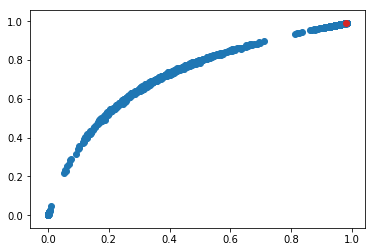

In [99]:
plt.scatter(w[:, 0], w[:, 1])
plt.scatter(w[555, 0], w[555, 1], c = 'C3')

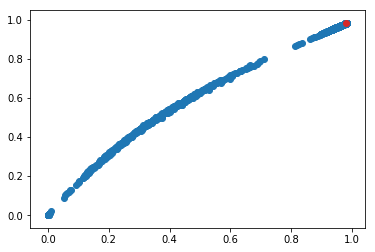

In [100]:
plt.scatter(w[:, 0], w[:, 2])
plt.scatter(w[555, 0], w[555, 2], c = 'C3')

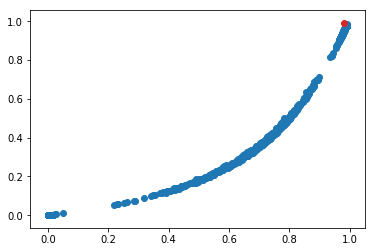

In [101]:
plt.scatter(w[:, 1], w[:, 0])
plt.scatter(w[555, 0], w[555, 1], c = 'C3')

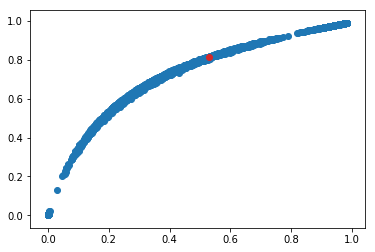

In [102]:
plt.scatter(z[:, 0], z[:, 1])
plt.scatter(z[555, 0], z[555, 1], c = 'C3')

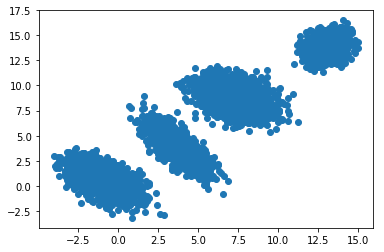

In [103]:
plt.scatter(lat[5000:,0], lat[5000:,1])

In [104]:
from sklearn.decomposition import PCA

In [105]:
pcs = PCA(n_components = 2)

In [106]:
q = pcs.fit_transform(lat)

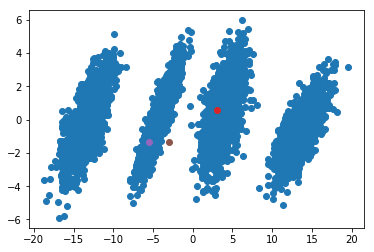

In [107]:
plt.figure()
plt.scatter(q[5000:, 0], q[5000:, 1])
plt.scatter(q[5555, 0], q[5555, 1], c= 'C3' )
plt.scatter(q[5505, 0], q[5505, 1], c= 'C4' )
plt.scatter(q[5005, 0], q[5505, 1], c= 'C5' )

In [108]:
other_pcs = PCA(n_components =2)

In [109]:
ww = other_pcs.fit_transform(w)

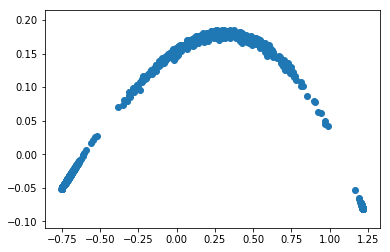

In [110]:
plt.figure()
plt.scatter(ww[:, 0], ww[:, 1])
#plt.scatter(ww[555, 0], ww[555, 0], c= 'C3' )
#plt.scatter(ww[505, 0], ww[505, 0], c= 'C4')
#plt.scatter(ww[5, 0], ww[5, 1], c= 'C5' )

In [111]:
cols = ['lat1', 'lat2', 'lat3', 'lat4', 'auto1', 'auto2', 'auto3', 'auto4',  'latpc1', 'latpc2', 'auto_pc1', 'auto_pc2', 'label']

In [112]:
lat[10000:, :].shape

(2000, 4)

In [113]:
labels = np.reshape(labels, (12000, 1))

In [114]:
dat = np.concatenate([lat[10000:, :], w, q[10000:, :], ww, labels[10000:, :]], axis = 1)

In [115]:
dat.shape

(2000, 13)

In [116]:
import pandas as pd

In [117]:
df = pd.DataFrame(data = dat, columns = cols)

In [118]:
df.head()

,lat1,lat2,lat3,lat4,auto1,auto2,auto3,auto4,latpc1,latpc2,auto_pc1,auto_pc2,label
0,-1.032392,1.214274,-0.216495,-0.278174,0.981392,0.989741,0.980982,0.982435,-12.639779,0.324079,-0.750240,-0.050281,0.0
1,12.672477,13.746170,11.297142,14.969165,0.000191,0.001015,0.000340,0.000459,13.885131,0.361043,1.215812,-0.080372,2.0
2,12.016325,13.223524,12.930940,12.074905,0.000582,0.003009,0.000990,0.001263,12.632186,-0.079275,1.213907,-0.079159,2.0
3,7.676754,8.288970,9.152671,8.078133,0.328181,0.677523,0.462372,0.445092,4.106311,0.225677,0.263404,0.182727,3.0
4,4.189989,4.902815,5.659531,3.733795,0.931741,0.973890,0.947037,0.945627,-3.254672,-0.179506,-0.681820,-0.027069,1.0


In [119]:
df['color'] = df['lat1']*df['lat2']*df['lat3'] *df['lat4']

In [120]:
import matplotlib
cmap = matplotlib.cm.get_cmap('viridis')
normalize = matplotlib.colors.Normalize(vmin=min(df.color), vmax=max(df.color))
colors = [cmap(normalize(i)) for i in df.color]

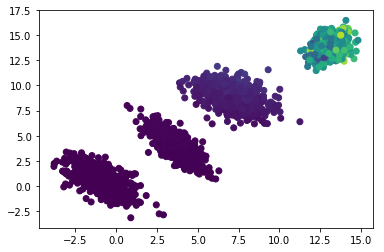

In [121]:
plt.scatter(df.lat1, df.lat2, c =colors)

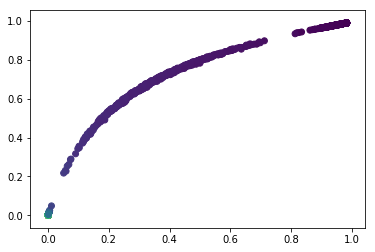

In [122]:
plt.scatter(df.auto1, df.auto2, c =colors)

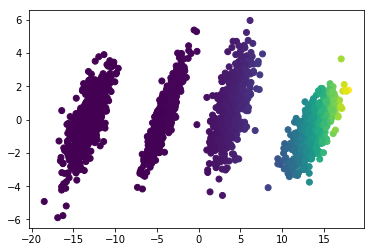

In [123]:
plt.scatter(df.latpc1, df.latpc2, c =colors)

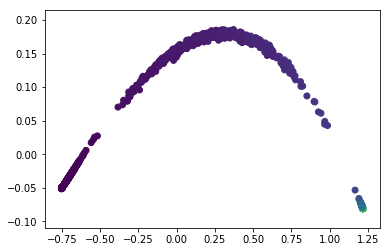

In [124]:
plt.scatter(df.auto_pc1, df.auto_pc2, c =colors)

In [125]:
pc_over_all = PCA(n_components = 2)

In [126]:
pc_over_samples = pc_over_all.fit_transform(samp[5000:, :])

Text(0,0.5,'pc2')

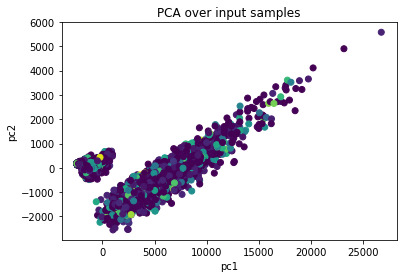

In [127]:
plt.scatter(pc_over_samples[:, 0], pc_over_samples[:, 1], c =colors)
plt.title('PCA over input samples')
plt.xlabel('pc1')
plt.ylabel('pc2')

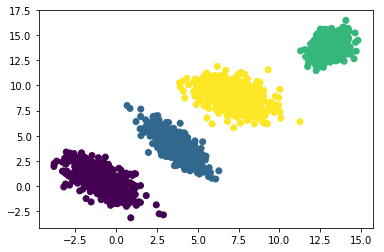

In [128]:
plt.scatter(df.lat1, df.lat2, c =df.label)

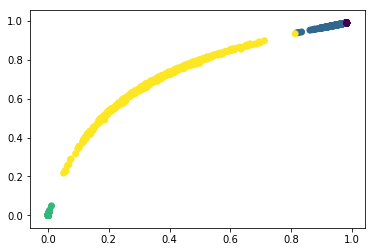

In [129]:
plt.scatter(df.auto1, df.auto2, c = df.label)

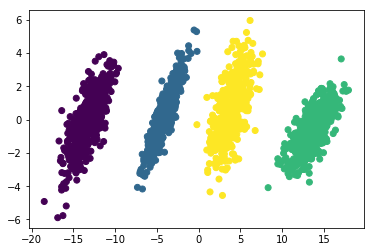

In [130]:
plt.scatter(df.latpc1, df.latpc2, c =df.label)

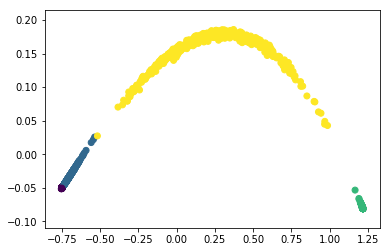

In [131]:
plt.scatter(df.auto_pc1, df.auto_pc2, c =df.label)

In [132]:
pc_over_all = PCA(n_components = 2)

In [133]:
pc_over_samples = pc_over_all.fit_transform(samp[10000:, :])

Text(0,0.5,'pc2')

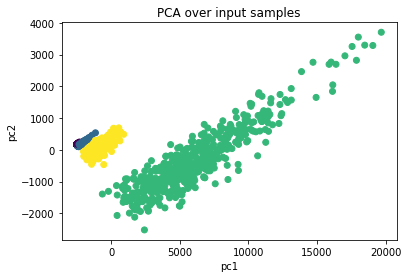

In [134]:
plt.scatter(pc_over_samples[:, 0], pc_over_samples[:, 1], c=df.label)
plt.title('PCA over input samples')
plt.xlabel('pc1')
plt.ylabel('pc2')